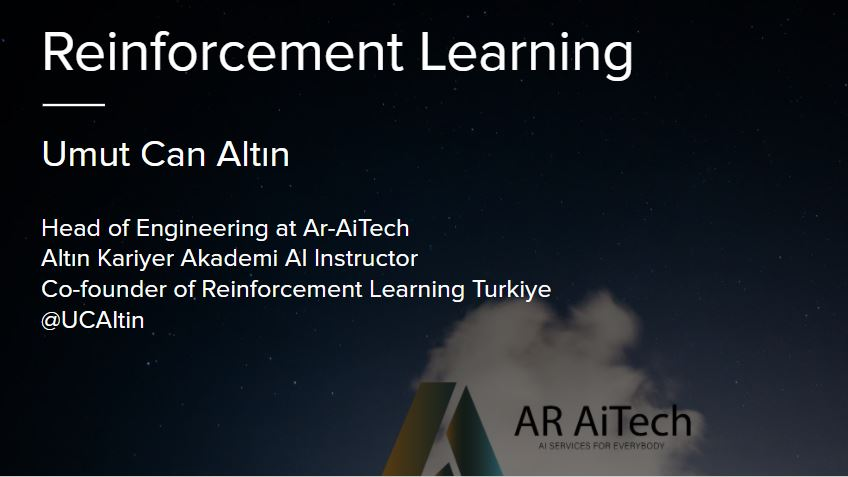



References


https://www.tensorflow.org/agents


Hafner, Danijar, James Davidson, and Vincent Vanhoucke. "Tensorflow agents: Efficient batched reinforcement learning in tensorflow." arXiv preprint arXiv:1709.02878 (2017).


Inside Tensorflow : Tf- Agents / slide


Sutton, Richard S., and Andrew G. Barto. "Reinforcement learning: An introduction." (2011).


Mnih, Volodymyr, et al. "Playing atari with deep reinforcement learning." arXiv preprint arXiv:1312.5602 (2013).


Lillicrap, Timothy P., et al. "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971 (2015).



Schulman, John, et al. "Proximal policy optimization algorithms." arXiv preprint arXiv:1707.06347 (2017).



Fujimoto, Scott, Herke Van Hoof, and David Meger. "Addressing function approximation error in actor-critic methods." arXiv preprint arXiv:1802.09477 (2018).



Haarnoja, Tuomas, et al. "Soft actor-critic: Off-policy maximum entropy deep reinforcement learning with a stochastic actor." arXiv preprint arXiv:1801.01290 (2018).

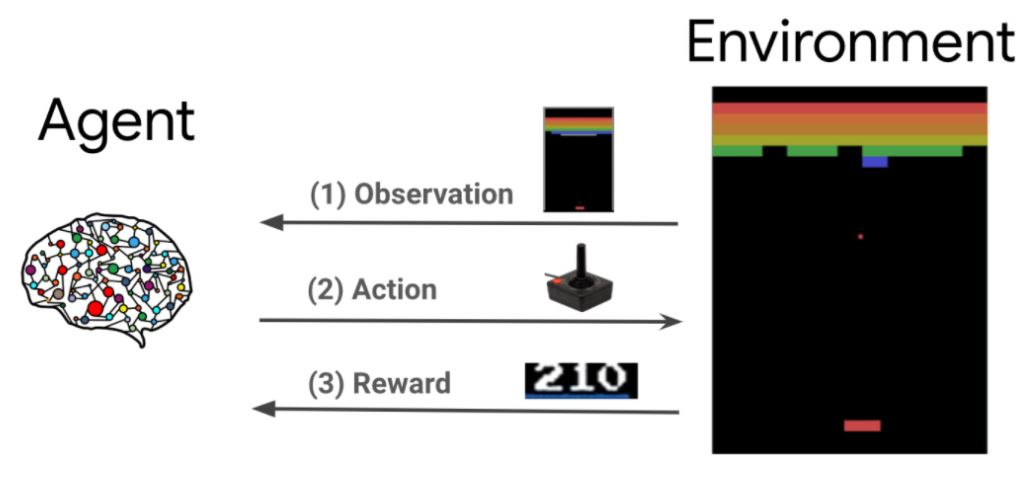

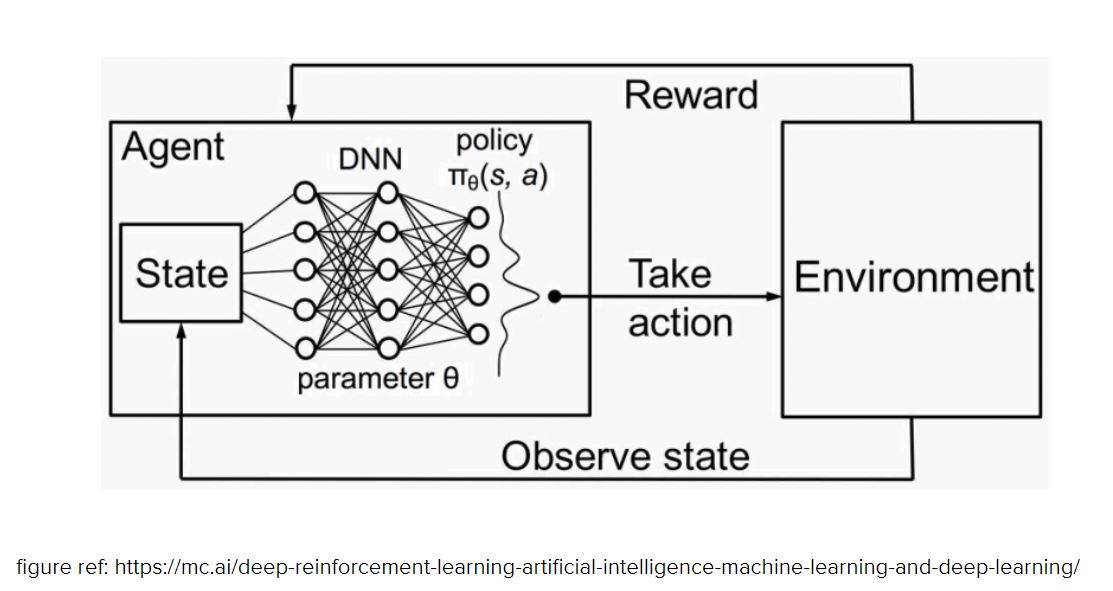

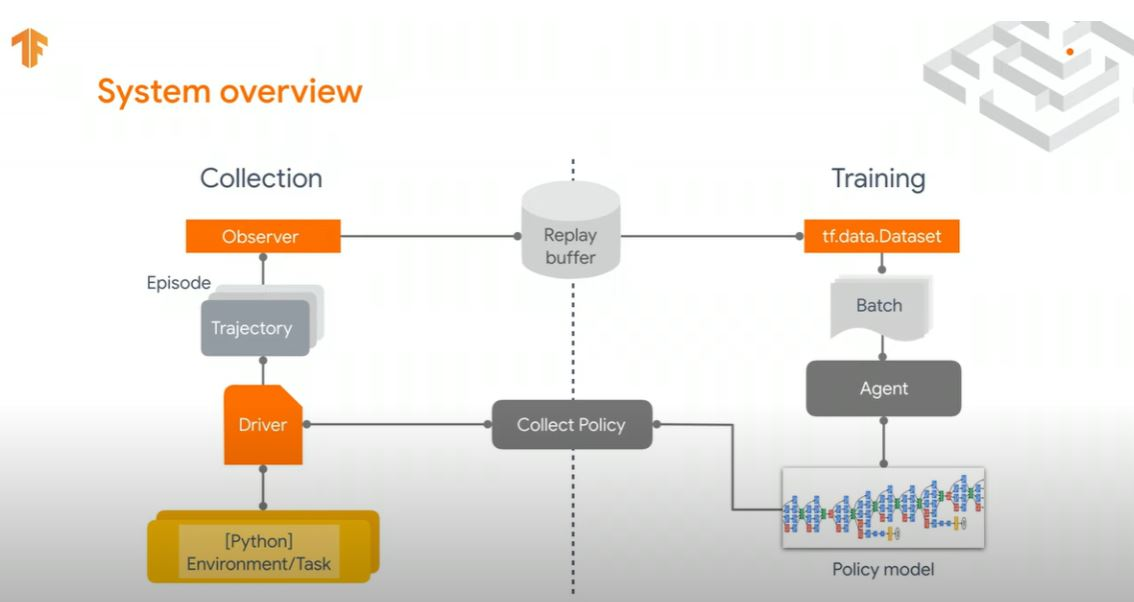

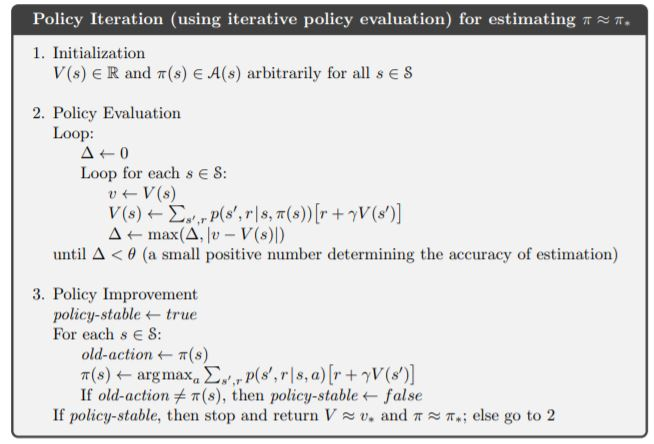


Aşağıdaki Kod parçası https://github.com/dennybritz/reinforcement-learning  reposundan alınmıştır.



In [ ]:
import numpy as np
import pprint
import sys
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.
    For example, a 4x4 grid looks as follows:
    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T
    x is your position and T are the two terminal states.
    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[4,4]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/tuple of length 2')

        self.shape = shape

        nS = np.prod(shape)
        nA = 4

        MAX_Y = shape[0]
        MAX_X = shape[1]

        P = {}
        grid = np.arange(nS).reshape(shape)
        it = np.nditer(grid, flags=['multi_index'])

        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            # P[s][a] = (prob, next_state, reward, is_done)
            P[s] = {a : [] for a in range(nA)}

            is_done = lambda s: s == 0 or s == (nS - 1)
            reward = 0.0 if is_done(s) else -1.0

            # We're stuck in a terminal state
            if is_done(s):
                P[s][UP] = [(1.0, s, reward, True)]
                P[s][RIGHT] = [(1.0, s, reward, True)]
                P[s][DOWN] = [(1.0, s, reward, True)]
                P[s][LEFT] = [(1.0, s, reward, True)]
            # Not a terminal state
            else:
                ns_up = s if y == 0 else s - MAX_X
                ns_right = s if x == (MAX_X - 1) else s + 1
                ns_down = s if y == (MAX_Y - 1) else s + MAX_X
                ns_left = s if x == 0 else s - 1
                P[s][UP] = [(1.0, ns_up, reward, is_done(ns_up))]
                P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
                P[s][DOWN] = [(1.0, ns_down, reward, is_done(ns_down))]
                P[s][LEFT] = [(1.0, ns_left, reward, is_done(ns_left))]

            it.iternext()

        # Initial state distribution is uniform
        isd = np.ones(nS) / nS

        # We expose the model of the environment for educational purposes
        # This should not be used in any model-free learning algorithm
        self.P = P

        super(GridworldEnv, self).__init__(nS, nA, P, isd)

    def _render(self, mode='human', close=False):
        """ Renders the current gridworld layout
         For example, a 4x4 grid with the mode="human" looks like:
            T  o  o  o
            o  x  o  o
            o  o  o  o
            o  o  o  T
        where x is your position and T are the two terminal states.
        """
        if close:
            return

        outfile = io.StringIO() if mode == 'ansi' else sys.stdout

        grid = np.arange(self.nS).reshape(self.shape)
        it = np.nditer(grid, flags=['multi_index'])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            if self.s == s:
                output = " x "
            elif s == 0 or s == self.nS - 1:
                output = " T "
            else:
                output = " o "

            if x == 0:
                output = output.lstrip()
            if x == self.shape[1] - 1:
                output = output.rstrip()

            outfile.write(output)

            if x == self.shape[1] - 1:
                outfile.write("\n")

            it.iternext()

pp = pprint.PrettyPrinter(indent=2)
env = GridworldEnv()

def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V

policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



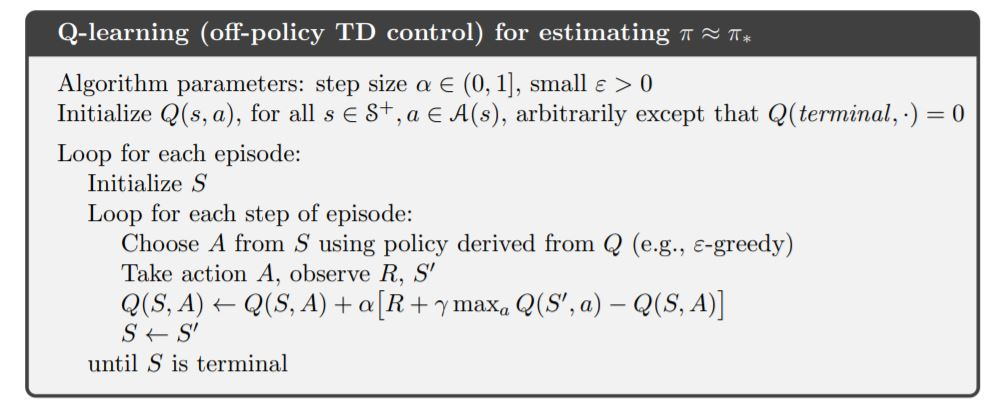

In [ ]:
import numpy as np
import random
from collections import defaultdict


class policy():
    def __init__(self, epsilon, action_space):
        
        self.epsilon=epsilon
        self.nA=action_space

    def probs(self,q_table,observation):
        A_probs = np.ones(self.nA, dtype=float) * self.epsilon / self.nA
        best_action = np.argmax(q_table[observation])
        A_probs[best_action] += (1 - self.epsilon)

        return A_probs


class q_learning_agent():
    def __init__(self, epsilon, discount_factor, alpha, action_space):
        self.q_table = defaultdict(lambda: np.zeros(action_space))
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.action_space = action_space
        self.alpha = alpha
        self.policy = policy(self.epsilon, self.action_space)

    def learn(self, action, reward, state, next_state):
        next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def select_action(self,state):
        A_probs = self.policy.probs(self.q_table,state)

        return np.random.choice(np.arange(len(A_probs)), p=A_probs)

    def get_q_table(self):
        return self.q_table

    def set_q_table(self, q_table):
        self.q_table = q_table

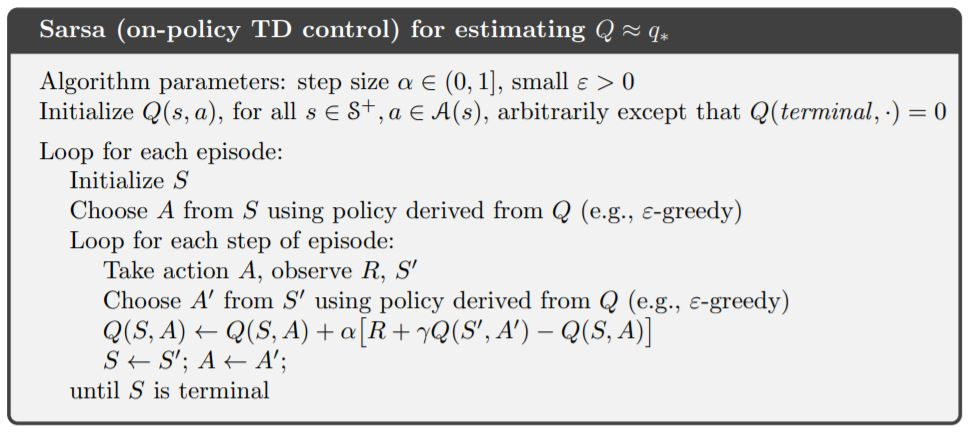

In [ ]:

class sarsa_learning_agent():
    def __init__(self, epsilon, discount_factor, alpha, action_space):
        self.q_table = defaultdict(lambda: np.zeros(action_space))
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.action_space = action_space
        self.alpha = alpha
        self.policy = policy(self.epsilon, self.action_space)

    def learn(self, action, reward, state, next_state):
        next_action = self.select_action(next_state)
        td_target = reward + self.discount_factor * self.q_table[next_state][next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def select_action(self,state):
        A_probs = self.policy.probs(self.q_table,state)

        return np.random.choice(np.arange(len(A_probs)), p=A_probs)

    def get_q_table(self):
        return self.q_table

    def set_q_table(self, q_table):
        self.q_table = q_table

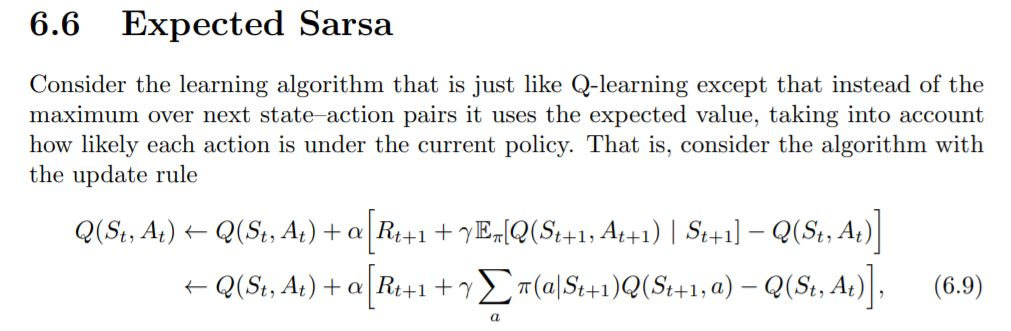

In [ ]:

class Expected_Sarsa_learning_agent():
    def init(self, epsilon, discount_factor,alpha, action_space):
        self.q_table = defaultdict(lambda: np.zeros(action_space))
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.action_space = action_space
        self.alpha = alpha
        self.policy = policy(self.epsilon, self.action_space)

    def learn(self, action, reward, state, next_state):
        A_probs = self.policy.probs(self.q_table,next_state)
        expected_value = np.dot(A_probs,self.q_table[next_state])
        td_target = reward + self.discount_factor * expected_value
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def select_action(self,state):
        A_probs = self.policy.probs(self.q_table, state)
        return np.random.choice(np.arange(len(A_probs)), p=A_probs)

    def get_Q_table(self):
        return self.q_table

    def set_Q_table(self, q_table):
        self.q_table = q_table

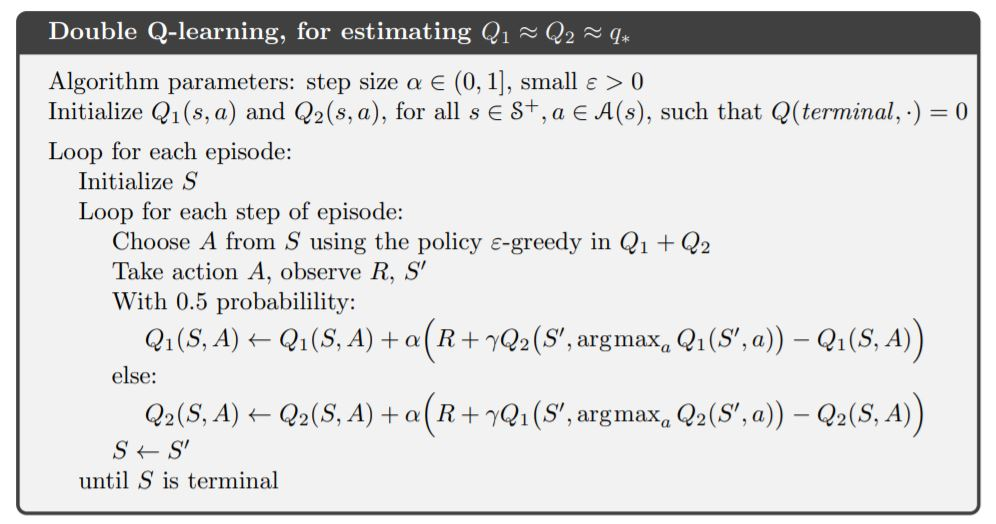

In [ ]:
class double_q_learning_agent():
    def __init__(self, epsilon, discount_factor, alpha, action_space):
        self.q_table_1 = defaultdict(lambda: np.zeros(action_space))
        self.q_table_2 = defaultdict(lambda: np.zeros(action_space))
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.action_space = action_space
        self.alpha = alpha
        self.policy = policy(self.epsilon, self.action_space)

    def learn(self, action, reward, state, next_state):
        if random.randint(1, 2) == 1:
            next_action = np.argmax(self.q_table_1[next_state])
            td_target = reward + self.discount_factor * self.q_table_2[next_state][next_action]
            td_error = td_target - self.q_table_1[state][action]
            self.q_table_1[state][action] += self.alpha * td_error
        else:
            next_action = np.argmax(self.q_table_2[next_state])
            td_target = reward + self.discount_factor * self.q_table_1[next_state][next_action]
            td_error = td_target - self.q_table_2[state][action]
            self.q_table_2[state][action] += self.alpha * td_error

    def select_action(self, state):
        A_probs_1 = self.policy.probs(self.q_table_2, state)
        A_probs_2 = self.policy.probs(self.q_table_1, state)

        return np.random.choice(np.arange(len(A_probs_1)), p=(A_probs_1+A_probs_2)/2)

    def get_q_tables(self):
        return [self.q_table_1, self.q_table_2]

    def set_q_table(self, q_table_1, q_table_2):
        self.q_table_1 = q_table_1
        self.q_table_2 = q_table_2

In [ ]:
import gym


env = gym.make("FrozenLake-v0")
env.reset()

def train(agent):
    for i_episode in range(1000):
        state = env.reset()
        while True:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(action, reward, state, next_state)
            if done:
                break
            state = next_state

qla = q_learning_agent(epsilon=0.3, discount_factor=0.9, alpha=0.5, action_space=env.action_space.n)
sla = sarsa_learning_agent(epsilon=0.3, discount_factor=0.9, alpha=0.5, action_space=env.action_space.n)
dqla = double_q_learning_agent(epsilon=0.3, discount_factor=0.9, alpha=0.5, action_space=env.action_space.n)

train(qla)
train(sla)
train(dqla)

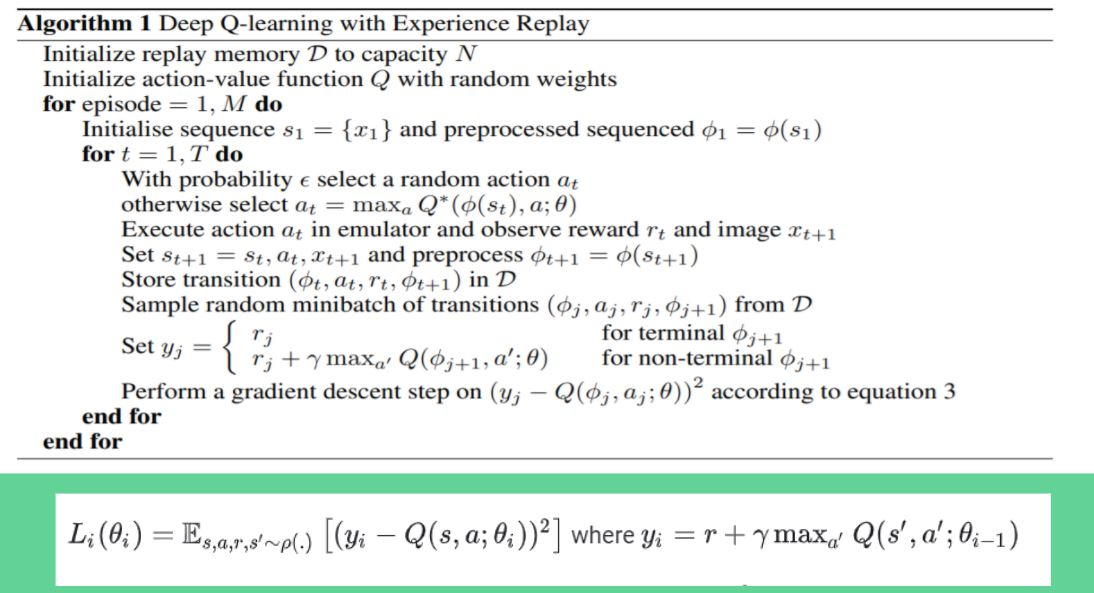

In [8]:
import numpy as np

class GeneticAgent:

    def __init__(self, population_size, chromosome_size, gene_variant,
                 elite_pop_size, mutation_chance, crossover_type, gym_env=True):
        self.population_size = population_size
        self.chromosome_size = chromosome_size
        self.gene_variant = gene_variant
        self.elite_pop_size = elite_pop_size
        self.mutation_chance = mutation_chance
        self.crossover_type = crossover_type
        self.gym_env = gym_env
        self.population = [np.random.randint(gene_variant, size=chromosome_size) for _ in range(population_size)]

    def select_elites(self, fitness_scores):
        population_ranks = list(reversed(np.argsort(fitness_scores)))
        return [self.population[x] for x in population_ranks[:self.elite_pop_size]]

    def select_parents(self, select_probs):

        return self.population[np.random.choice(range(self.population_size), p=select_probs)],\
            self.population[np.random.choice(range(self.population_size), p=select_probs)]

    def generate_new_population(self, fitness_scores):
        select_probs = np.array(fitness_scores) / np.sum(fitness_scores)
        child_set = []
        for generate in range(int((self.population_size-self.elite_pop_size)/2)):
            if self.crossover_type == "digit":
                children = self.cross_over_with_digit(self.select_parents(select_probs))
            else:
                children = self.cross_over_with_pieces(self.select_parents(select_probs))
            child_set.append(children[0])
            child_set.append(children[1])
        self.population = child_set + self.select_elites(fitness_scores=fitness_scores)

    def cross_over_with_digit(self, parents):
        children = {0: np.random.randint(self.gene_variant, size=self.chromosome_size),
                    1: np.random.randint(self.gene_variant, size=self.chromosome_size)}
        for child in range(2):
            for gene in range(self.chromosome_size):
                if np.random.uniform() < self.mutation_chance:
                    children[child][gene] = np.random.randint(4)
                else:
                    if np.random.uniform() < 0.5:
                        children[child][gene] = parents[0][gene]
                    else:
                        children[child][gene] = parents[1][gene]
        return children[0], children[1]

    def cross_over_with_pieces(self, parents):
        pos = np.random.randint(self.chromosome_size)
        child1 = np.concatenate((parents[0][:pos], parents[1][pos:]), axis=0)
        child2 = np.concatenate((parents[0][pos:], parents[1][:pos]), axis=0)
        for i in np.arange(self.chromosome_size):
            if np.random.uniform() < self.mutation_chance:
                child1[i] = np.random.randint(self.gene_variant)
        for i in np.arange(self.chromosome_size):
            if np.random.uniform() < self.mutation_chance:
                child2[i] = np.random.randint(self.gene_variant)
        return child1, child2

    def gym_play(self, env, total_game_number):
        fitness_scores = []
        if self.gym_env:

            for individual in self.population:
                total_reward = 0
                for ep in range(total_game_number):
                    state = env.reset()
                    while True:
                        # play from the policy (agent includes a action for every state)
                        action = individual[state]
                        next_state, reward, done, _ = env.step(action)
                        if done:
                            total_reward += reward
                            break
                        state = next_state
                fitness_scores.append(total_reward / total_game_number)
            return fitness_scores

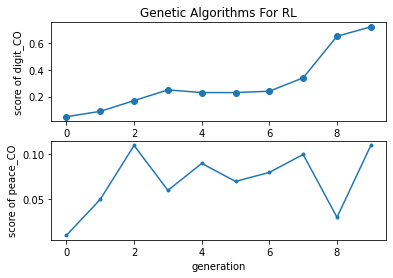

In [10]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker


env = gym.make("FrozenLake-v0")
genetic_agent = GeneticAgent(population_size=10, chromosome_size=env.observation_space.n, gene_variant=env.action_space.n,
                             elite_pop_size=4, mutation_chance=0.01, crossover_type="digit", gym_env=True)

best_scores_with_digit_crossover = []
best_scores_with_peaces_crossover = []
total_game_number = 10
total_generation_number = 10

for generation in range(total_generation_number):
    fitness_scores = genetic_agent.gym_play(env, total_game_number=total_game_number)
    genetic_agent.generate_new_population(fitness_scores)
    generation_score = np.average(fitness_scores)
    best_scores_with_digit_crossover.append(generation_score)


genetic_agent = GeneticAgent(population_size=10, chromosome_size=env.observation_space.n, gene_variant=env.action_space.n,
                             elite_pop_size=6, mutation_chance=0.01, crossover_type="piece", gym_env=True)
fitness_scores = []
for generation in range(total_generation_number):
    fitness_scores = genetic_agent.gym_play(env, total_game_number=total_game_number)
    generation_score = np.average(fitness_scores)
    best_scores_with_peaces_crossover.append(generation_score)
    genetic_agent.generate_new_population(fitness_scores)

y1 = best_scores_with_digit_crossover
y2 = best_scores_with_peaces_crossover

x = np.arange(total_generation_number)

plt.subplot(2, 1, 1)
plt.plot(x, y1, 'o-')
plt.title('Genetic Algorithms For RL')
plt.ylabel('score of digit_CO')
locator = ticker.MultipleLocator(2)
plt.gca().xaxis.set_major_locator(locator)
plt.subplot(2, 1, 2)
plt.plot(x, y2, '.-')
plt.xlabel('generation')
plt.ylabel('score of peace_CO')
plt.gca().xaxis.set_major_locator(locator)
plt.show()